In [60]:
#Kaggle tweet classification!

In [61]:
import pandas as pd

In [62]:
Disaster_Train = pd.read_excel('Disaster_Train.xlsx')

In [63]:
Disaster_Train.columns

Index(['id', 'keyword', 'location', 'text', 'target'], dtype='object')

In [64]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, BertTokenizerFast



In [65]:
# specify GPU
device = torch.device("cpu")

In [66]:
del Disaster_Train['id']
del Disaster_Train['keyword']
del Disaster_Train['location']

In [67]:
Disaster_Train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [68]:
# split train dataset into train, validation and test sets
train_text, temp_text, train_labels, temp_labels = train_test_split(Disaster_Train['text'], Disaster_Train['target'], 
                                                                    random_state=2018, 
                                                                    test_size=0.3, 
                                                                    stratify=Disaster_Train['target'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.5, 
                                                                stratify=temp_labels)

In [69]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [70]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    return text

In [71]:
import re
#import nltk

In [72]:
Disaster_Train['text'] = Disaster_Train['text'].apply(initial_clean)

In [73]:
Disaster_Train['text']

0       our deeds are the reason of this earthquake ma...
1                   forest fire near la ronge sask canada
2       all residents asked to shelter in place are be...
3        people receive wildfires evacuation orders in...
4       just got sent this photo from ruby alaska as s...
                              ...                        
7608    two giant cranes holding a bridge collapse int...
7609        the out of control wild fires in californi...
7610                       m  utckm s of volcano hawaii  
7611    police investigating after an ebike collided w...
7612    the latest more homes razed by northern califo...
Name: text, Length: 7613, dtype: object

In [74]:
#from spellchecker import SpellChecker

In [75]:
# spell = SpellChecker()

# # find those words that may be misspelled
# misspelled = spell.unknown(['something', 'is', 'hapenning', 'here'])

# for word in Disaster_Train['text']:
#     # Get the one `most likely` answer
#     print(spell.correction(word))

#     # Get a list of `likely` options
#     print(spell.candidates(word))

In [76]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True)

# output
print(sent_id)

{'input_ids': [[101, 2023, 2003, 1037, 14324, 2944, 14924, 4818, 102], [101, 2057, 2097, 2986, 1011, 8694, 1037, 14324, 2944, 102]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [77]:
import matplotlib

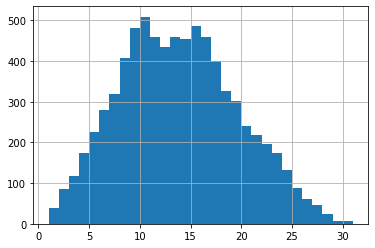

In [78]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in Disaster_Train['text']]

pd.Series(seq_len).hist(bins = 30)

In [79]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 30,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [80]:
## convert lists to tensors

train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [81]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [82]:
# # freeze all the parameters
# for param in bert.parameters():
#     param.requires_grad = False

In [83]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
      
      super(BERT_Arch, self).__init__()

      self.bert = bert 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [84]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)

In [85]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate

In [86]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_weights = compute_class_weight('balanced', np.unique(train_labels), train_labels)

print("Class Weights:",class_weights)

Class Weights: [0.87676867 1.16353712]


C:\Users\akn19\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1], y=6802    1
3997    1
4742    1
2034    0
2961    1
       ..
5564    0
1818    1
5464    1
354     1
2918    0
Name: target, Length: 5329, dtype: int64 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [87]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)

# push to GPU
weights = weights.to(device)

# define the loss function
cross_entropy  = nn.NLLLoss(weight=weights) 

# number of training epochs
epochs = 10

In [88]:
# function to train the model
def train():
  
  model.train()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step,batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

    # push the batch to gpu
    batch = [r.to(device) for r in batch]
 
    sent_id, mask, labels = batch

    # clear previously calculated gradients 
    model.zero_grad()        

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  #returns the loss and predictions
  return avg_loss, total_preds

In [89]:
# function for evaluating the model
def evaluate():
  
  print("\nEvaluating...")
  
  # deactivate dropout layers
  model.eval()

  total_loss, total_accuracy = 0, 0
  
  # empty list to save the model predictions
  total_preds = []

  # iterate over batches
  for step,batch in enumerate(val_dataloader):
    
    # Progress update every 50 batches.
    if step % 50 == 0 and not step == 0:
      
      # Calculate elapsed time in minutes.
      elapsed = format_time(time.time() - t0)
            
      # Report progress.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    # push the batch to gpu
    batch = [t.to(device) for t in batch]

    sent_id, mask, labels = batch

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      preds = model(sent_id, mask)

      # compute the validation loss between actual and predicted values
      loss = cross_entropy(preds,labels)

      total_loss = total_loss + loss.item()

      preds = preds.detach().cpu().numpy()

      total_preds.append(preds)

  # compute the validation loss of the epoch
  avg_loss = total_loss / len(val_dataloader) 

  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)

  return avg_loss, total_preds

In [90]:
# set initial loss to infinite
best_valid_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 10
  Batch    50  of    167.
  Batch   100  of    167.
  Batch   150  of    167.

Evaluating...

Training Loss: 0.514
Validation Loss: 0.441

 Epoch 2 / 10
  Batch    50  of    167.
  Batch   100  of    167.
  Batch   150  of    167.

Evaluating...

Training Loss: 0.389
Validation Loss: 0.441

 Epoch 3 / 10
  Batch    50  of    167.
  Batch   100  of    167.
  Batch   150  of    167.

Evaluating...

Training Loss: 0.328
Validation Loss: 0.488

 Epoch 4 / 10
  Batch    50  of    167.
  Batch   100  of    167.
  Batch   150  of    167.

Evaluating...

Training Loss: 0.259
Validation Loss: 0.516

 Epoch 5 / 10
  Batch    50  of    167.
  Batch   100  of    167.
  Batch   150  of    167.

Evaluating...

Training Loss: 0.215
Validation Loss: 0.535

 Epoch 6 / 10
  Batch    50  of    167.
  Batch   100  of    167.
  Batch   150  of    167.

Evaluating...

Training Loss: 0.176
Validation Loss: 0.605

 Epoch 7 / 10
  Batch    50  of    167.
  Batch   100  of    167.
  Batch   150  

In [91]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [92]:
# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds = preds.detach().cpu().numpy()

In [93]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85       652
           1       0.80      0.79      0.80       490

    accuracy                           0.83      1142
   macro avg       0.83      0.82      0.82      1142
weighted avg       0.83      0.83      0.83      1142



In [94]:
#Importing Libraries for obtaining metrics!
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [95]:
# The metrics for the model are printed below!

accuracy_test = accuracy_score(test_y, preds)
precision_test = precision_score(test_y, preds)
recall_test = recall_score(test_y, preds )
f1_test = f1_score(test_y, preds)
confusion_mat_test = confusion_matrix(test_y, preds )

print("accuracy_test =",accuracy_test*100,"%")
print("precision_test =",precision_test*100,"%")
print("recall_test =",recall_test*100,"%")
print("f1_test =",f1_test*100,"%")
print("confusion_mat_test =")
print(confusion_mat_test)

accuracy_test = 82.83712784588442 %
precision_test = 80.49792531120332 %
recall_test = 79.18367346938776 %
f1_test = 79.83539094650206 %
confusion_mat_test =
[[558  94]
 [102 388]]


In [96]:
submission  = pd.read_excel('C:/Users/akn19/Desktop/Kaggle/1/Test.xlsx')

In [97]:
del submission['id']
del submission['keyword']
del submission['location']

In [98]:
submission['text'] = submission['text'].apply(initial_clean)

In [99]:
# tokenize and encode sequences in the submission set
tokens_sub = tokenizer.batch_encode_plus(
    submission['text'].tolist(),
    max_length = 25,
    pad_to_max_length=True,
    truncation=True
)

In [100]:
sub_seq = torch.tensor(tokens_sub['input_ids'])
sub_mask = torch.tensor(tokens_sub['attention_mask'])
#sub_y = torch.tensor(submission_lable.tolist())

In [101]:
# get predictions for test data
with torch.no_grad():
  preds_sub = model(sub_seq.to(device), sub_mask.to(device))
  preds_sub = preds_sub.detach().cpu().numpy()

In [102]:
preds_sub = np.argmax(preds_sub, axis = 1)

In [103]:
preds_sub

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [104]:
submission['target'] = preds_sub

In [105]:
submission.head(5)

,text,target
0,just happened a terrible car crash,1
1,heard about earthquake is different cities sta...,1
2,there is a forest fire at spot pond geese are ...,1
3,apocalypse lighting spokane wildfires,1
4,typhoon soudelor kills in china and taiwan,1


In [106]:
submission.to_csv('submission2.csv')

In [120]:
git remote add origin https://github.com/AnirudhDataSoldier/NLP.git
git branch -M main
git push -u origin main

SyntaxError: invalid syntax (<ipython-input-120-6d05fd211e26>, line 1)

In [118]:
pip install python-git

Note: you may need to restart the kernel to use updated packages.


In [119]:
import pygit as git

In [109]:
pip install gitpython

Note: you may need to restart the kernel to use updated packages.
